<a href="https://colab.research.google.com/github/Alaa-Hesham11/image_classification/blob/main/Image_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
📦 Extracting: pizza.zip...
✅ Extraction completed!
🚀 Final dataset path: /content/pizza_dataset_working/pizza_not_pizza

📊 Data summary:
       Class  Count
0      pizza    983
1  not_pizza    983


/tmp/ipython-input-1649867461.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='Oranges')


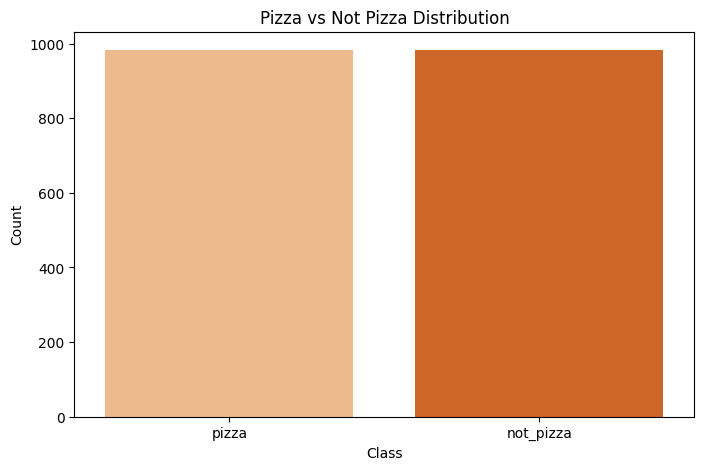

In [1]:
import os
import shutil
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Set new paths for the pizza dataset
# Note: Make sure you "Add Shortcut to Drive" for the folder from the provided link
drive_path = "/content/drive/MyDrive/pizza_dataset"
extract_path = "/content/pizza_dataset_working"

# 3️⃣ Automatic extraction
# The code will search for any .zip file inside the folder and extract it
if os.path.exists(drive_path):
    zip_files = [f for f in os.listdir(drive_path) if f.endswith('.zip')]
    if zip_files:
        zip_file_name = zip_files[0] # takes the first zip file found
        zip_full_path = os.path.join(drive_path, zip_file_name)

        print(f"📦 Extracting: {zip_file_name}...")
        with zipfile.ZipFile(zip_full_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("✅ Extraction completed!")
    else:
        print("❌ No zip files found in the folder.")
else:
    print(f"❌ Path does not exist: {drive_path}. Make sure the folder name in My Drive is correct.")

# 4️⃣ Set the final dataset path
# Sometimes extraction creates an inner folder with the same name; this code ensures the correct folder is used
dataset_path = extract_path
items_in_extract = os.listdir(extract_path) if os.path.exists(extract_path) else []
if len(items_in_extract) == 1 and os.path.isdir(os.path.join(extract_path, items_in_extract[0])):
    dataset_path = os.path.join(extract_path, items_in_extract[0])

print("🚀 Final dataset path:", dataset_path)

# 5️⃣ Show pizza images statistics (Pizza vs Not Pizza)
data_info = []
if os.path.exists(dataset_path):
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            num_images = len([f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            data_info.append({'Class': label, 'Count': num_images})

df = pd.DataFrame(data_info)
if not df.empty:
    print("\n📊 Data summary:")
    print(df)

    # 6️⃣ Plot chart for image distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Class', y='Count', data=df, palette='Oranges')
    plt.title('Pizza vs Not Pizza Distribution')
    plt.show()
else:
    print("⚠️ No class folders found in the dataset path.")


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Image Preprocessing and Data Augmentation ---
# This step fulfills the requirement for Data Preprocessing.
# We apply normalization and random transformations to prevent overfitting.

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images
    width_shift_range=0.2,     # Randomly shift images horizontally
    height_shift_range=0.2,    # Randomly shift images vertically
    shear_range=0.2,           # Apply shear mapping
    zoom_range=0.2,            # Randomly zoom in/out
    horizontal_flip=True,      # Flip images horizontally
    fill_mode='nearest',       # Fill empty pixels after transformation
    validation_split=0.2       # Reserve 20% of data for validation
)

# --- Training Generator ---
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# --- Validation Generator ---
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False             # Set to False for proper evaluation later
)

print(f"Preprocessing Complete: {train_generator.class_indices}")
print(f"✅ Total images for training: {train_generator.samples}")
print(f"✅ Total images for validation: {validation_generator.samples}")

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Preprocessing Complete: {'not_pizza': 0, 'pizza': 1}
✅ Total images for training: 1574
✅ Total images for validation: 392


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

# (MobileNetV2)
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Pizza Classification Model is Ready!")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Pizza Classification Model is Ready!


In [4]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5314 - loss: 0.8931 - val_accuracy: 0.6276 - val_loss: 0.6485
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6159 - loss: 0.7208 - val_accuracy: 0.7041 - val_loss: 0.5535
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6637 - loss: 0.6426 - val_accuracy: 0.7679 - val_loss: 0.4859
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7083 - loss: 0.5782 - val_accuracy: 0.8036 - val_loss: 0.4384
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7538 - loss: 0.5492 - val_accuracy: 0.8291 - val_loss: 0.4139
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7732 - loss: 0.4779 - val_accuracy: 0.8520 - val_loss: 0.3770
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7996 - loss: 0.4376 - val_accuracy: 0.8750 - val_loss: 0.3391
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8140 - loss: 0.4298 - val_accuracy: 0.8776 - val_loss:

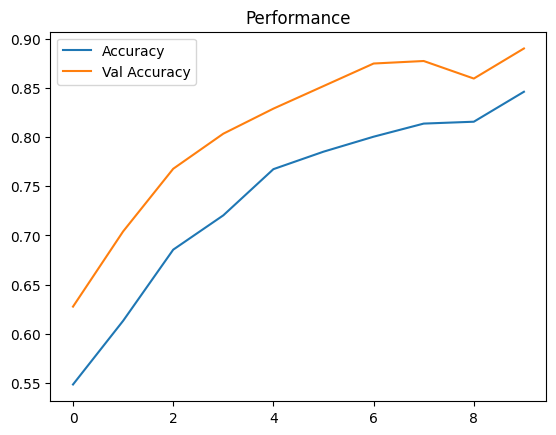

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Performance')
plt.legend()
plt.show()

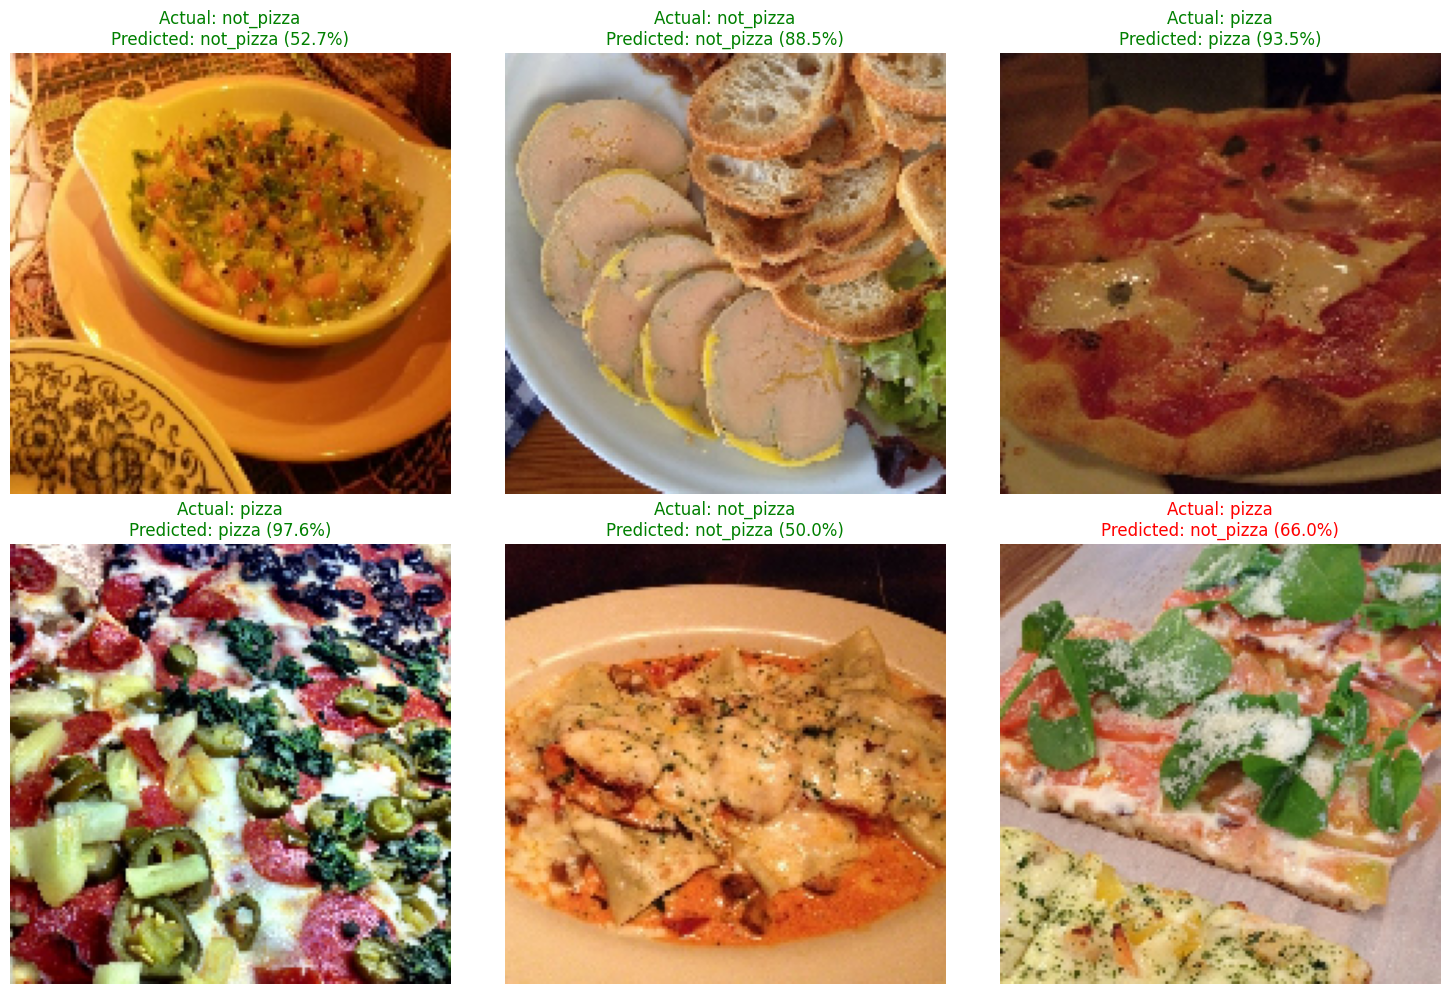

In [6]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_and_show_results(num_images=6):
    # Make sure the model and dataset path exist
    if 'model' not in globals() or not os.path.exists(dataset_path):
        print("❌ Model is not ready or dataset path is incorrect!")
        return

    plt.figure(figsize=(15, 10))

    # Get actual folder names (usually: pizza and not_pizza)
    all_categories = [
        d for d in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, d))
    ]

    # Class order is important: Keras usually sorts alphabetically
    # Example: 'not_pizza' -> 0, 'pizza' -> 1
    # We get this directly from the training generator
    class_indices = train_generator.class_indices

    # Reverse the dictionary to map index -> class name
    labels_map = {v: k for k, v in class_indices.items()}

    for i in range(num_images):
        # Randomly choose a class and an image from it
        category = random.choice(all_categories)
        category_path = os.path.join(dataset_path, category)

        valid_images = [
            img for img in os.listdir(category_path)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        if not valid_images:
            continue

        img_name = random.choice(valid_images)
        img_path = os.path.join(category_path, img_name)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(160, 160))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prediction
        prediction = model.predict(img_array, verbose=0)[0][0]

        # Decide class based on 0.5 threshold
        pred_idx = 1 if prediction > 0.5 else 0
        predicted_label = labels_map[pred_idx]

        # Confidence percentage
        confidence = prediction * 100 if pred_idx == 1 else (1 - prediction) * 100

        # Green if prediction matches the actual folder, otherwise red
        color = 'green' if predicted_label.lower() == category.lower() else 'red'

        # Plot the image
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(
            f"Actual: {category}\nPredicted: {predicted_label} ({confidence:.1f}%)",
            color=color
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Run the test
predict_and_show_results()


13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 915ms/step
--- Classification Report ---
              precision    recall  f1-score   support

   not_pizza       0.87      0.90      0.88       196
       pizza       0.89      0.87      0.88       196

    accuracy                           0.88       392
   macro avg       0.88      0.88      0.88       392
weighted avg       0.88      0.88      0.88       392



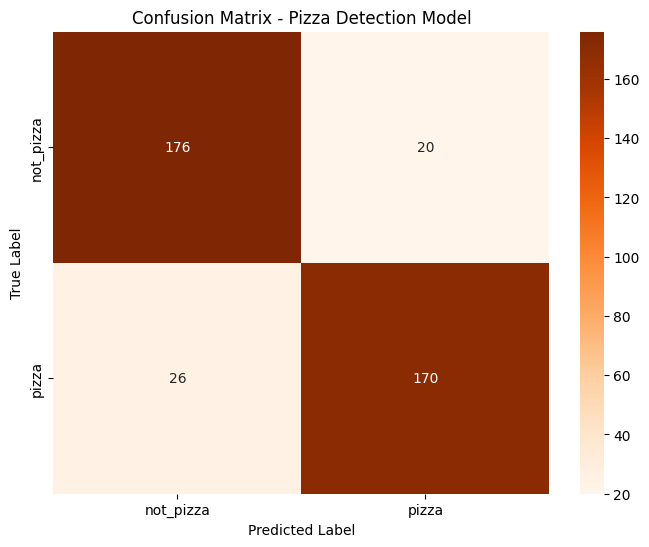

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Reset the generator and disable shuffle for consistent evaluation
validation_generator.reset()
validation_generator.shuffle = False

# 2. Predict labels using the trained model
Y_pred = model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype(int)

# 3. Get true labels and dynamic class names (e.g., ['not_pizza', 'pizza'])
y_true = validation_generator.classes
target_names = list(validation_generator.class_indices.keys())

# 4. Print the Classification Report
print('--- Classification Report ---')
print(classification_report(y_true, y_pred, target_names=target_names))

# 5. Generate and plot the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)



plt.title('Confusion Matrix - Pizza Detection Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Convert image data from the generator into NumPy arrays
def get_data_for_ml(generator):
    X, y = [], []

    # Take a limited number of batches to save time and memory
    for i in range(len(generator)):
        imgs, labels = generator[i]

        for img, label in zip(imgs, labels):
            # Flatten image from (160, 160, 3) into a single 1D vector
            X.append(img.flatten())
            y.append(label)

        if i > 10:
            break  # Take enough data for fast training

    return np.array(X), np.array(y)

# Extract training and validation data
X_train, y_train = get_data_for_ml(train_generator)
X_val, y_val = get_data_for_ml(validation_generator)

print("Data is ready ✅")


Data is ready ✅


In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#
rf_preds = rf_model.predict(X_val)
rf_acc = accuracy_score(y_val, rf_preds)
print(f"Random Forest accuracy : {rf_acc:.2%}")

Random Forest accuracy : 63.54%


In [10]:
# Create and Train SVM Model
# We use a linear kernel for faster processing with image pixels
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

# Evaluate SVM Model
svm_preds = svm_model.predict(X_val)
svm_acc = accuracy_score(y_val, svm_preds)

print(f"SVM Model Accuracy: {svm_acc:.2%}")

SVM Model Accuracy: 58.59%


/tmp/ipython-input-2712737071.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')


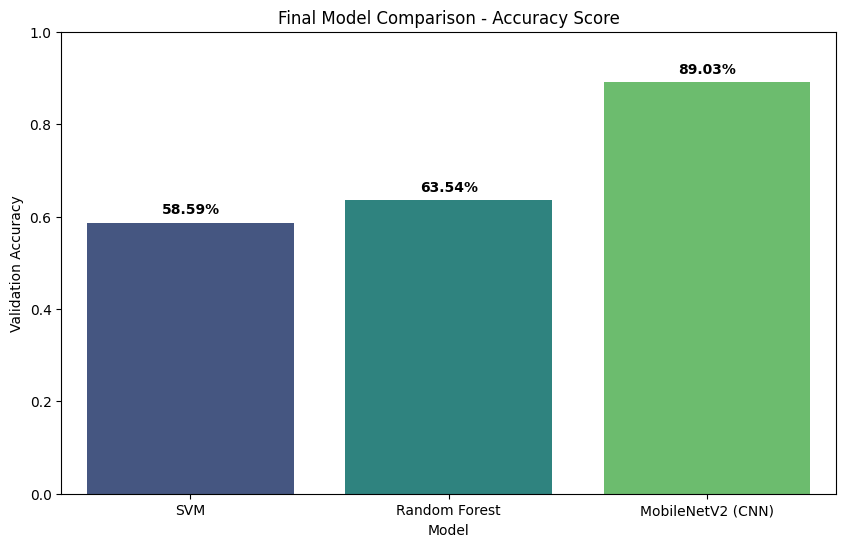


--- Project Summary Report ---
               Model  Accuracy
2  MobileNetV2 (CNN)  0.890306
1      Random Forest  0.635417
0                SVM  0.585938


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Collect accuracy results from the three trained models
# Ensure variable names (svm_acc, rf_acc, history) match your previous cells
model_names = ['SVM', 'Random Forest', 'MobileNetV2 (CNN)']
accuracies = [svm_acc, rf_acc, history.history['val_accuracy'][-1]]

# 2. Create the Comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# 3. Plot the Comparison Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.ylim(0, 1.0)
plt.title('Final Model Comparison - Accuracy Score')
plt.ylabel('Validation Accuracy')

# Add percentage labels on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2%}', ha='center', fontweight='bold')

plt.show()

# 4. Print the Final Summary Table
print("\n--- Project Summary Report ---")
print(comparison_df.sort_values(by='Accuracy', ascending=False))

In [12]:
# --- Hyper-parameter Tuning Step ---
# Initial testing with Learning Rate = 0.001 showed high oscillations in Loss.
# The Learning Rate was tuned to 0.0001 to ensure training stability
# and achieve higher validation accuracy.

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=custom_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Hyper-parameter Tuning: Learning Rate set to 0.0001 for better stability.")

Hyper-parameter Tuning: Learning Rate set to 0.0001 for better stability.


In [13]:
# 1. Install Gradio
!pip install gradio -q

import gradio as gr

# 2. Define the Prediction Function
def predict_pizza(img):
    # Preprocess the uploaded image to match model input (160x160)
    img_resized = np.array(img)
    img_resized = tf.image.resize(img_resized, (160, 160))
    img_array = img_resized / 255.0  # Normalization
    img_array = np.expand_dims(img_array, axis=0)

    # Get prediction from your MobileNetV2 model
    prediction = model.predict(img_array, verbose=0)[0][0]

    # Determine label based on 0.5 threshold
    # Note: 1 is usually Pizza and 0 is Not Pizza based on your generator
    if prediction > 0.5:
        confidence = prediction * 100
        return f"Prediction: PIZZA 🍕 ({confidence:.2f}%)"
    else:
        confidence = (1 - prediction) * 100
        return f"Prediction: NOT PIZZA 🚫 ({confidence:.2f}%)"

# 3. Create the Gradio Web Interface
interface = gr.Interface(
    fn=predict_pizza,
    inputs=gr.Image(label="Upload Image"),
    outputs=gr.Text(label="Result"),
    title="Pizza Detection System",
    description="Upload an image to check if it's a Pizza or not using our trained CNN model."
)

# 4. Launch the App
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://42e00b394fe340df18.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
